In [3]:
from IPython.display import Image

# Text Classification

La clasificación de texto es una de las tareas más comunes en NLP; puede usarse para una amplia gama de aplicaciones, como etiquetar comentarios de clientes en categorías o enrutar tickets de soporte según su idioma. Es probable que el filtro de spam de tu programa de correo electrónico esté utilizando clasificación de texto para proteger tu bandeja de entrada de una avalancha de basura no deseada!

Otro tipo común de clasificación de texto es el sentiment analysis, que  tiene como objetivo identificar la polaridad de un texto dado. Por ejemplo, una empresa como Tesla podría analizar publicaciones de Twitter como la de la Figura 2-1 para determinar si a la gente le gustan o no sus nuevos techos de automóviles.

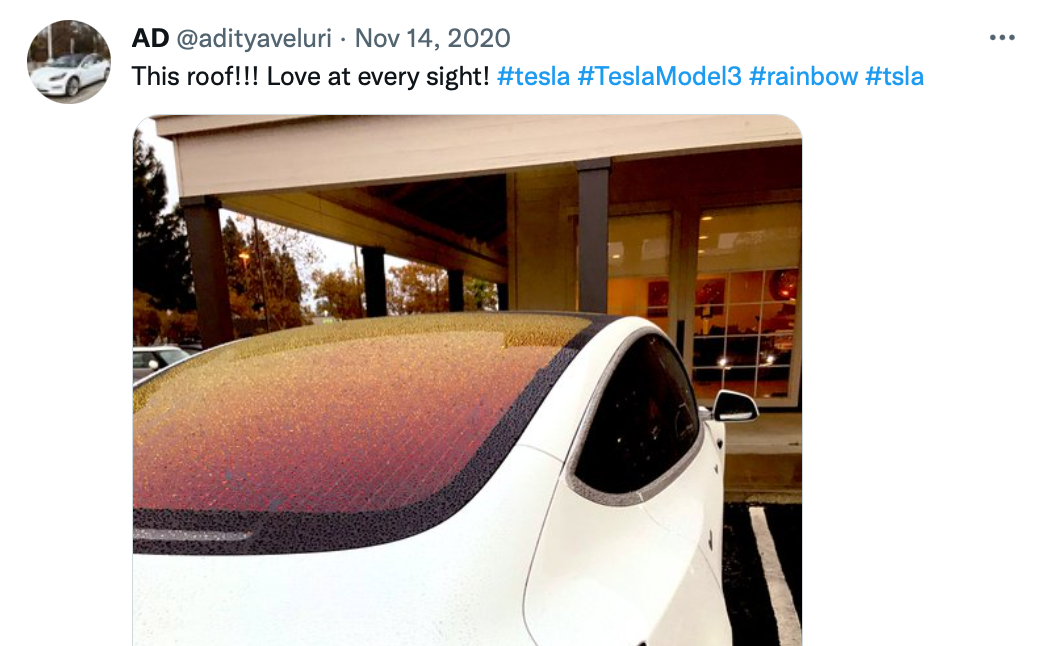

In [7]:
Image("images/chapter02_tweet.png", width=500)

Ahora imagina que eres un científico de datos que necesita construir un sistema que pueda identificar automáticamente estados emocionales como "anger" o "joy" que las personas expresan sobre el producto de tu empresa en Twitter. En este capítulo, abordaremos esta tarea utilizando una variante de BERT llamada DistilBERT. La principal ventaja de este modelo es que logra un rendimiento comparable a BERT, siendo significativamente más pequeño y eficiente. Esto nos permite entrenar un clasificador en unos minutos, y si quieres entrenar un modelo BERT más grande, simplemente puedes cambiar el checkpoint del modelo preentrenado. Un checkpoint corresponde al conjunto de pesos que se cargan en una arquitectura transformer dada.

Este también será nuestro primer encuentro con tres de las bibliotecas principales del ecosistema de Hugging Face:
🤗 Datasets,
🤗 Tokenizers, y
🤗 Transformers. 

Como se muestra en la Figura 2-2, estas bibliotecas nos permitirán pasar rápidamente de texto sin procesar a un modelo fine-tuned que se puede usar para inferencia en nuevos tweets. Así que, en el espíritu de Optimus Prime, ¡sumerjámonos, "transform, and roll out!"

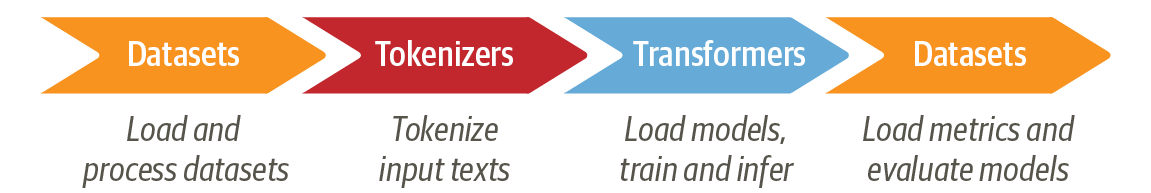

In [5]:
Image("images/chapter02_hf-libraries.png", width=700)

## El Dataset

Para construir nuestro detector de emociones, usaremos un excelente dataset de un artículo que exploró cómo se representan las emociones en los mensajes de Twitter en inglés. A diferencia de la mayoría de los datasets de sentiment analysis que involucran solo polaridades "positive" y "negative", este dataset contiene seis emociones básicas: anger, disgust, fear, joy, sadness y surprise. Dado un tweet, nuestra tarea será entrenar un modelo que pueda clasificarlo en una de estas emociones.

### Una Primera Mirada a Hugging Face Datasets

Usaremos 🤗 Datasets para descargar los datos del [Hugging Face Hub](https://huggingface.co/datasets). Podemos usar la función `list_datasets()` para ver qué datasets están disponibles en el Hub:

In [ ]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 1753 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


Vemos que a cada dataset se le asigna un nombre, así que carguemos el dataset `emotion` con la función `load_dataset()`:

In [ ]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

Si miramos dentro de nuestro objeto `emotions`:

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

vemos que es similar a un diccionario de Python, con cada clave correspondiente a un split diferente. Y podemos usar la sintaxis habitual de diccionario para acceder a un split individual:

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

que devuelve una instancia de la clase `Dataset`. El objeto `Dataset` es una de las estructuras de datos centrales en 🤗 Datasets, y exploraremos muchas de sus características a lo largo de este libro. Para empezar, se comporta como un array o lista ordinaria de Python, por lo que podemos consultar su longitud:

In [ ]:
len(train_ds)

16000

o acceder a un solo ejemplo por su índice:

In [ ]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Aquí vemos que una sola fila está representada como un diccionario, donde las claves corresponden a los nombres de las columnas:

In [ ]:
train_ds.column_names

['text', 'label']

y los valores son el tweet y la emoción. Esto refleja el hecho de que 🤗 Datasets se basa en [_Apache Arrow_](https://arrow.apache.org/), que define un formato columnar tipado que es más eficiente en memoria que el Python nativo. Podemos ver qué tipos de datos se están utilizando internamente accediendo al atributo `features` de un objeto `Dataset`:

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6,
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None,
id=None)}


En este caso, el tipo de datos de la columna `text` es `string`, mientras que la columna `label` es un objeto `ClassLabel` especial que contiene información sobre los nombres de las clases y su mapeo a enteros. También podemos acceder a varias filas con un slice:

In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


Ten en cuenta que en este caso, los valores del diccionario son ahora listas en lugar de elementos individuales. También podemos obtener la columna completa por nombre:

In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


Ahora que hemos visto cómo cargar e inspeccionar datos con 🤗 Datasets, hagamos algunas comprobaciones de cordura sobre el contenido de nuestros tweets.

> #### ¿Qué pasa si mi Dataset no está en el Hub?

Usaremos el Hugging Face Hub para descargar datasets para la mayoría de los ejemplos. Pero en muchos casos, te encontrarás trabajando con datos que están almacenados en tu laptop o en un servidor remoto en tu organización. 🤗 Datasets proporciona varios scripts de carga para manejar datasets locales y remotos. En <<dataset-loading>> se muestran ejemplos para los formatos de datos más comunes.

Cómo cargar datasets en varios formatos

| Formato de datos | Script de carga | Ejemplo |
| --- | --- | --- |
| CSV | `csv` | `load_dataset("csv", data_files="my_file.csv")` |
| Text | `text` | `load_dataset("text", data_files="my_file.txt")` |
| JSON | `json` | `load_dataset("json", data_files="my_file.jsonl")` |

Como puedes ver, para cada formato de datos, solo necesitamos pasar el script de carga relevante a la función `load_dataset()`, junto con un argumento `data_files` que especifica la ruta o URL a uno o más archivos. Por ejemplo, los archivos fuente para el dataset `emotion` están realmente alojados en Dropbox, por lo que una forma alternativa de cargar el dataset es primero descargar uno de los splits:

In [ ]:
# The original URL used in the book is no longer available, so we use a different one
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

Si te preguntas por qué hay un carácter `!` en el comando de shell anterior, es porque estamos ejecutando los comandos en un notebook Jupyter. Simplemente elimina el prefijo si quieres descargar y descomprimir el dataset dentro de una terminal. Ahora, si echamos un vistazo a la primera fila del archivo _train.txt_:

In [ ]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


podemos ver que no hay encabezados de columna y cada tweet y emoción están separados por un punto y coma. Sin embargo, esto es bastante similar a un archivo CSV, por lo que podemos cargar el dataset localmente usando el script `csv` y apuntando el argumento `data_files` al archivo _train.txt_:

In [ ]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])

Aquí también hemos especificado el tipo de delimitador y los nombres de las columnas. Un enfoque aún más simple es simplemente apuntar el argumento `data_files` a la URL misma:

In [ ]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"])

que descargará y almacenará en caché automáticamente el dataset para ti. Como puedes ver, la función `load_dataset()` es muy versátil. Recomendamos consultar la [documentation](https://huggingface.co/docs/datasets/loading.html) de 🤗 Datasets para obtener una visión general completa.

### De Datasets a DataFrames

Aunque 🤗 Datasets proporciona mucha funcionalidad de bajo nivel para cortar y dividir nuestros datos, a menudo es conveniente convertir un objeto `Dataset` en un `DataFrame` de Pandas para poder acceder a APIs de alto nivel para la visualización de datos. Para habilitar la conversión, 🤗 Datasets proporciona un método `set_format()` que nos permite cambiar el _formato de salida_ del `Dataset`. Ten en cuenta que esto no cambia el _formato de datos_ subyacente (que es una tabla Arrow), y puedes cambiar a otro formato más tarde si es necesario:

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Como puedes ver, los encabezados de las columnas se han conservado y las primeras filas coinciden con nuestras vistas anteriores de los datos. Sin embargo, las etiquetas están representadas como enteros, así que usemos el método `int2str()` de la característica `label` para crear una nueva columna en nuestro `DataFrame` con los nombres de etiquetas correspondientes:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Antes de sumergirnos en la construcción de un clasificador, echemos un vistazo más cercano al conjunto de datos. Como nota Andrej Karpathy en su famoso post de blog ["Una receta para entrenar redes neuronales"](https://karpathy.github.io/2019/04/25/recipe), convertirse en "uno con los datos" es un paso esencial para entrenar modelos excelentes.

### Observando la Distribución de Clases

Siempre que estés trabajando en problemas de clasificación de texto, es una buena idea examinar la distribución de ejemplos en las clases. Un conjunto de datos con una distribución de clases sesgada podría requerir un tratamiento diferente en términos de la pérdida de entrenamiento y las métricas de evaluación que uno equilibrado. 

Con Pandas y Matplotlib, podemos visualizar rápidamente la distribución de clases de la siguiente manera:

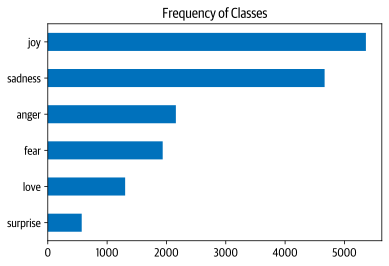

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

En este caso, podemos ver que el conjunto de datos está muy desequilibrado; las clases `joy` y `sadness` aparecen con frecuencia, mientras que `love` y `surprise` son aproximadamente 5-10 veces más raras. Hay varias formas de lidiar con datos desequilibrados, incluyendo:

* Sobremuestrear aleatoriamente la clase minoritaria.
* Submuestrear aleatoriamente la clase mayoritaria.
* Recopilar más datos etiquetados de las clases subrepresentadas.

Para mantener las cosas simples en este capítulo, trabajaremos con las frecuencias de clases crudas y desequilibradas. Si deseas aprender más sobre estas técnicas de muestreo, recomendamos echar un vistazo a la [biblioteca Imbalanced-learn](https://imbalanced-learn.org/stable/). ¡Asegúrate de no aplicar métodos de muestreo _antes_ de crear tus divisiones de entrenamiento/prueba, o tendrás mucha fuga entre ellas!

Ahora que hemos visto las clases, echemos un vistazo a los tweets mismos.

### Que tan largos son nuestros Tweets?

Los modelos Transformer tienen una longitud máxima de secuencia de entrada que se refiere como el _tamaño máximo de contexto_. Para aplicaciones que usan DistilBERT, el tamaño máximo de contexto es de 512 tokens, lo que equivale a unos pocos párrafos de texto. Como veremos en la próxima sección, un token es una pieza atómica de texto; por ahora, trataremos un token como una sola palabra. Podemos obtener una estimación aproximada de las longitudes de los tweets por emoción examinando la distribución de palabras por tweet:

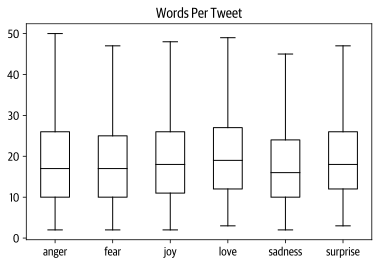

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Desde el gráfico vemos que para cada emoción, la mayoría de los tweets tienen alrededor de 15 palabras y los tweets más largos están muy por debajo del tamaño máximo de contexto de DistilBERT. Los textos que son más largos que el tamaño de contexto de un modelo necesitan ser truncados, lo que puede llevar a una pérdida de rendimiento si el texto truncado contiene información crucial; en este caso, parece que eso no será un problema. 

¡Ahora vamos a averiguar cómo podemos convertir estos textos crudos en un formato adecuado para los Transformers de hugging face! Mientras estamos en ello, también vamos a restablecer el formato de salida de nuestro conjunto de datos ya que ya no necesitamos el formato `DataFrame`: 

In [ ]:
emotions.reset_format()

## De Texto a Tokens

Los modelos Transformer como DistilBERT no pueden recibir cadenas de texto sin procesar como entrada; en su lugar, asumen que el texto ha sido _tokenizado_ y _codificado_ como vectores numéricos. La tokenización es el paso de dividir una cadena en las unidades atómicas utilizadas en el modelo. Existen varias estrategias de tokenización que se pueden adoptar, y la división óptima de palabras en subunidades generalmente se aprende del corpus. Antes de observar el tokenizer utilizado para DistilBERT, consideremos dos casos extremos: la tokenización a nivel de _carácter_ y a nivel de _palabra_.

### Tokenización a Nivel de Carácter

El esquema de tokenización más simple es alimentar cada carácter individualmente al modelo. En Python, los objetos `str` son realmente arrays bajo el capó, lo que nos permite implementar rápidamente la tokenización a nivel de carácter con solo una línea de código:

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


Este es un buen comienzo, pero aún no hemos terminado. Nuestro modelo espera que cada carácter se convierta en un entero, un proceso a veces llamado _numericalization_. Una forma simple de hacer esto es codificar cada token único (que en este caso son caracteres) con un entero único:

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


Esto nos da un mapeo de cada carácter en nuestro vocabulario a un entero único. Ahora podemos usar `token2idx` para transformar el texto tokenizado en una lista de enteros:

In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Cada token ahora ha sido mapeado a un identificador numérico único (de ahí el nombre `input_ids`). El último paso es convertir `input_ids` en un tensor 2D de vectores one-hot. Los vectores one-hot se utilizan frecuentemente en machine learning para codificar datos categóricos, que pueden ser ordinales o nominales. Por ejemplo, supongamos que queremos codificar los nombres de los personajes en la serie de TV _Transformers_. Una forma de hacer esto sería mapear cada nombre a un ID único, de la siguiente manera:


In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


El problema con este enfoque es que crea un orden ficticio entre los nombres, y las redes neuronales son _realmente_ buenas para aprender este tipo de relaciones. Así que en su lugar, podemos crear una nueva columna para cada categoría y asignar un 1 donde la categoría sea verdadera, y un 0 en caso contrario. En Pandas, esto se puede implementar con la función `get_dummies()` de la siguiente manera:

In [ ]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


Las filas de este `DataFrame` son los vectores one-hot, que tienen una sola entrada "caliente" con un 1 y 0s en todas partes. Ahora, mirando nuestros `input_ids`, tenemos un problema similar: los elementos crean una escala ordinal. Esto significa que sumar o restar dos IDs es una operación sin sentido, ya que el resultado es un nuevo ID que representa otro token aleatorio.


Por otro lado, el resultado de sumar dos codificaciones one-hot puede interpretarse fácilmente: las dos entradas que están "calientes" indican que los tokens correspondientes co-ocurren. Podemos crear las codificaciones one-hot en PyTorch convirtiendo `input_ids` en un tensor y aplicando la función `one_hot()` de la siguiente manera:

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

Para cada uno de los 38 tokens de entrada, ahora tenemos un vector one-hot con 20 dimensiones, ya que nuestro vocabulario consta de 20 caracteres únicos.

> Advertencia: Es importante siempre establecer `num_classes` en la función `one_hot()` porque de lo contrario los vectores one-hot pueden terminar siendo más cortos que la longitud del vocabulario (y necesitar ser rellenados con ceros manualmente).

Al examinar el primer vector, podemos verificar que aparece un 1 en la ubicación indicada por `input_ids[0]`:

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


En nuestro simple ejemplo podemos ver que la tokenización a nivel de carácter ignora cualquier estructura en el texto y trata toda la cadena como un flujo de caracteres. Aunque esto ayuda a lidiar con errores ortográficos y palabras raras, el principal inconveniente es que las estructuras lingüísticas como las palabras necesitan ser _aprendidas_ a partir de los datos. Esto requiere un cómputo, memoria y datos significativos. Por esta razón, la tokenización a nivel de carácter rara vez se usa en la práctica. En su lugar, se preserva alguna estructura del texto durante el paso de tokenización. La _tokenización a nivel de palabra_ es un enfoque sencillo para lograr esto, así que veamos cómo funciona.

### Word Tokenization

En lugar de dividir el texto en caracteres, podemos dividirlo en palabras y mapear cada palabra a un entero. Usar palabras desde el principio permite al modelo omitir el paso de aprender palabras a partir de caracteres, y así reducir la complejidad del proceso de entrenamiento.

Una clase simple de tokenizers de palabras usa espacios en blanco para tokenizar el texto. Podemos hacer esto aplicando directamente la función `split()` de Python en el texto sin procesar (tal como hicimos para medir las longitudes de los tweets):

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


A partir de aquí podemos seguir los mismos pasos que tomamos para el tokenizer de caracteres para mapear cada palabra a un ID. Sin embargo, ya podemos ver un problema potencial con este esquema de tokenización: la puntuación no se tiene en cuenta, por lo que `NLP.` se trata como un solo token. Dado que las palabras pueden incluir declinaciones, conjugaciones o errores ortográficos, el tamaño del vocabulario puede crecer fácilmente hasta los millones!

> nota: Algunos tokenizers de palabras tienen reglas adicionales para la puntuación. También se puede aplicar stemming o lematización, que normaliza las palabras a su raíz (por ejemplo, "great", "greater" y "greatest" se convierten en "great"), a costa de perder algo de información en el texto.

Tener un vocabulario grande es un problema porque requiere que las redes neuronales tengan una cantidad enorme de parámetros. Para ilustrar esto, supongamos que tenemos 1 millón de palabras únicas y queremos comprimir los vectores de entrada de 1 millón de dimensiones a vectores de 1 mil dimensiones en la primera capa de nuestra red neuronal. Este es un paso estándar en la mayoría de las arquitecturas de NLP, y la matriz de pesos resultante de esta primera capa contendría 1 millón $\times$ 1 mil = 1 mil millones de pesos. Esto ya es comparable al modelo GPT-2 más grande, que tiene alrededor de 1.5 mil millones de parámetros en total!

Naturalmente, queremos evitar ser tan derrochadores con los parámetros de nuestro modelo, ya que los modelos son costosos de entrenar, y los modelos más grandes son más difíciles de mantener. Un enfoque común es limitar el vocabulario y descartar palabras raras considerando, por ejemplo, las 100,000 palabras más comunes en el corpus. Las palabras que no forman parte del vocabulario se clasifican como "desconocidas" y se asignan a un token compartido `UNK`. Esto significa que perdemos alguna información potencialmente importante en el proceso de tokenización de palabras, ya que el modelo no tiene información sobre las palabras asociadas con `UNK`.

¿No sería genial si hubiera un compromiso entre la tokenización a nivel de carácter y la tokenización a nivel de palabra que preservara toda la información de entrada _y_ parte de la estructura de entrada? Existe: la _tokenización a nivel de subpalabra_.


### Subword Tokenization

La idea básica detrás de la tokenización a nivel de subpalabra es combinar los mejores aspectos de la tokenización a nivel de carácter y a nivel de palabra. Por un lado, queremos dividir las palabras raras en unidades más pequeñas para permitir que el modelo maneje palabras complejas y errores ortográficos. Por otro lado, queremos mantener las palabras frecuentes como entidades únicas para que podamos mantener la longitud de nuestras entradas a un tamaño manejable. La característica principal que distingue la tokenización a nivel de subpalabra (así como la tokenización a nivel de palabra) es que se _aprende_ del corpus de preentrenamiento utilizando una mezcla de reglas estadísticas y algoritmos.

Existen varios algoritmos de tokenización a nivel de subpalabra que se utilizan comúnmente en NLP, pero comencemos con WordPiece, que es utilizado por los tokenizers de BERT y DistilBERT. La forma más fácil de entender cómo funciona WordPiece es verlo en acción. Hugging Face Transformers proporciona una clase conveniente `AutoTokenizer` que te permite cargar rápidamente el tokenizer asociado con un modelo preentrenado: simplemente llamamos a su método `from_pretrained()`, proporcionando el ID de un modelo en el Hub o una ruta de archivo local. Comencemos cargando el tokenizer para DistilBERT:

In [ ]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

La clase `AutoTokenizer` pertenece a un conjunto más grande de ["clases automáticas"](https://huggingface.co/docs/transformers/model_doc/auto) cuyo trabajo es recuperar automáticamente la configuración del modelo, los pesos preentrenados o el vocabulario a partir del nombre del checkpoint. Esto te permite cambiar rápidamente entre modelos, pero si deseas cargar la clase específica manualmente, también puedes hacerlo. Por ejemplo, podríamos haber cargado el tokenizer de DistilBERT de la siguiente manera:


```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

> nota: Cuando ejecutas el método `AutoTokenizer.from_pretrained()` por primera vez, verás una barra de progreso que muestra qué parámetros del tokenizer preentrenado se están cargando desde el Hugging Face Hub. Cuando ejecutes el código por segunda vez, cargará el tokenizer desde la caché, generalmente ubicada en _~/.cache/huggingface/_.

Examinemos cómo funciona este tokenizer alimentándole nuestro simple texto de ejemplo "Tokenizing text is a core task of NLP.":

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Al igual que vimos con la tokenización a nivel de carácter, podemos ver que las palabras han sido mapeadas a enteros únicos en el campo `input_ids`. Discutiremos el papel del campo `attention_mask` en la siguiente sección. Ahora que tenemos los `input_ids`, podemos convertirlos de nuevo en tokens utilizando el método `convert_ids_to_tokens()` del tokenizer:

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


Podemos observar tres cosas aquí. Primero, se han añadido algunos tokens especiales `[CLS]` y `[SEP]` al inicio y al final de la secuencia. Estos tokens difieren de un modelo a otro, pero su función principal es indicar el inicio y el final de una secuencia. Segundo, los tokens han sido convertidos a minúsculas, lo cual es una característica de este checkpoint en particular. Finalmente, podemos ver que "tokenizing" y "NLP" se han dividido en dos tokens, lo cual tiene sentido ya que no son palabras comunes. El prefijo `##` en `##izing` y `##p` significa que la cadena anterior no es un espacio en blanco; cualquier token con este prefijo debe fusionarse con el token anterior cuando conviertas los tokens de nuevo en una cadena. La clase `AutoTokenizer` tiene un método `convert_tokens_to_string()` para hacer precisamente eso, así que apliquémoslo a nuestros tokens:

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


La clase `AutoTokenizer` también tiene varios atributos que proporcionan información sobre el tokenizer. Por ejemplo, podemos inspeccionar el tamaño del vocabulario:

In [ ]:
tokenizer.vocab_size

30522

y el tamaño máximo de contexto del modelo correspondiente:

In [ ]:
tokenizer.model_max_length

512

Otro atributo interesante a conocer es el nombre de los campos que el modelo espera en su paso hacia adelante:

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Ahora que tenemos una comprensión básica del proceso de tokenización para una sola cadena, veamos cómo podemos tokenizar todo el conjunto de datos!

> advertencia: Cuando uses modelos preentrenados, es _realmente_ importante asegurarte de que usas el mismo tokenizer con el que se entrenó el modelo. Desde la perspectiva del modelo, cambiar el tokenizer es como barajar el vocabulario. Si todos a tu alrededor comenzaran a intercambiar palabras aleatorias como "casa" por "gato", también tendrías dificultades para entender lo que está pasando!

### Tokenizando Todo el Conjunto de Datos

Para tokenizar todo el corpus, usaremos el método `map()` de nuestro objeto `DatasetDict`. Nos encontraremos con este método muchas veces a lo largo de este libro, ya que proporciona una forma conveniente de aplicar una función de procesamiento a cada elemento en un conjunto de datos. Como veremos pronto, el método `map()` también se puede usar para crear nuevas filas y columnas.

Para empezar, lo primero que necesitamos es una función de procesamiento para tokenizar nuestros ejemplos:

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Esta función aplica el tokenizer a un lote de ejemplos; `padding=True` rellenará los ejemplos con ceros al tamaño del más largo en un lote, y `truncation=True` truncará los ejemplos al tamaño máximo de contexto del modelo. Para ver `tokenize()` en acción, pasemos un lote de dos ejemplos del conjunto de entrenamiento:

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


Aquí podemos ver el resultado del relleno (padding): el primer elemento de `input_ids` es más corto que el segundo, por lo que se han añadido ceros a ese elemento para hacerlos del mismo tamaño. Estos ceros tienen un token `[PAD]` correspondiente en el vocabulario, y el conjunto de tokens especiales también incluye los tokens `[CLS]` y `[SEP]` que encontramos anteriormente:

In [ ]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


También ten en cuenta que además de devolver los tweets codificados como `input_ids`, el tokenizer devuelve una lista de arrays `attention_mask`. Esto se debe a que no queremos que el modelo se confunda con los tokens de relleno adicionales: la máscara de atención permite que el modelo ignore las partes rellenadas de la entrada. La figura siguiente proporciona una explicación visual de cómo se rellenan los IDs de entrada y las máscaras de atención.

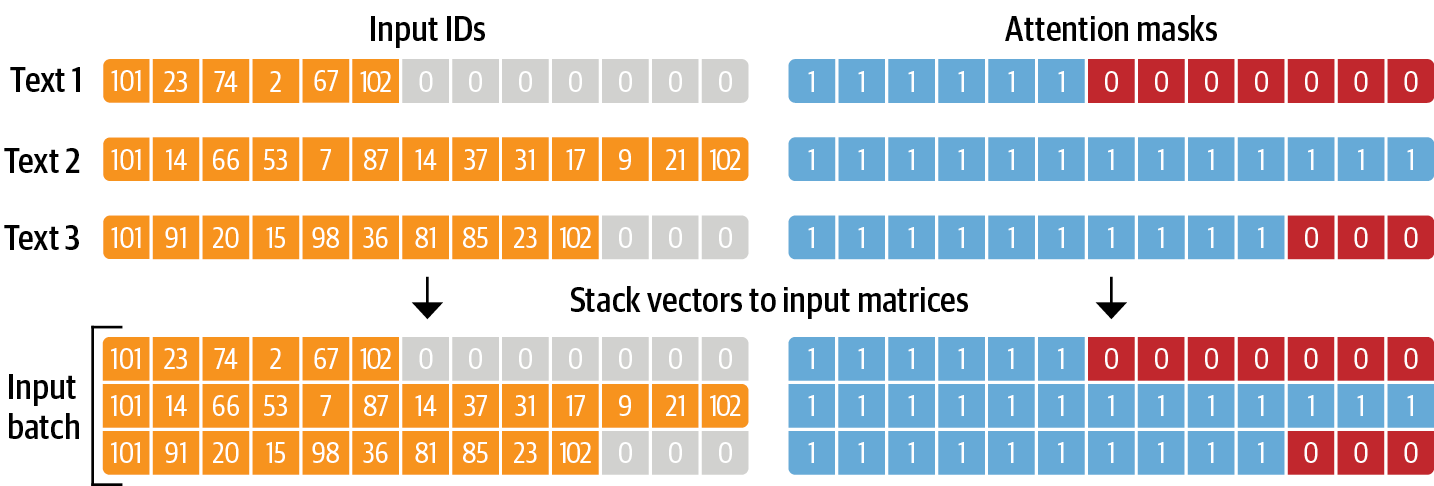

In [10]:
Image("images/chapter02_attention-mask.png", width=800)

Una vez que hemos definido una función de procesamiento, podemos aplicarla a todos los splits en el corpus en una sola línea de código:

In [ ]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Por defecto, el método `map()` opera individualmente en cada ejemplo en el corpus, por lo que establecer `batched=True` codificará los tweets en lotes. Debido a que hemos establecido `batch_size=None`, nuestra función `tokenize()` se aplicará al conjunto de datos completo como un solo lote. Esto asegura que los tensores de entrada y las máscaras de atención tengan la misma forma globalmente, y podemos ver que esta operación ha añadido nuevas columnas `input_ids` y `attention_mask` al conjunto de datos:

In [ ]:
print(emotions_encoded["train"].column_names)

['attention_mask', 'input_ids', 'label', 'text']


> Nota: Los _data collators_ se pueden usar para rellenar dinámicamente los tensores en cada lote. El relleno (padding) global será útil en la siguiente sección, donde extraemos una matriz de características de todo el corpus.

## Entrenando un Clasificador de Texto

Como se discutió anteriormente, los modelos como DistilBERT están preentrenados para predecir palabras enmascaradas en una secuencia de texto. Sin embargo, no podemos usar estos modelos de lenguaje directamente para la clasificación de texto; necesitamos modificarlos ligeramente. Para entender qué modificaciones son necesarias, echemos un vistazo a la arquitectura de un modelo basado en encoder como DistilBERT, que se muestra en la siguiente figura.

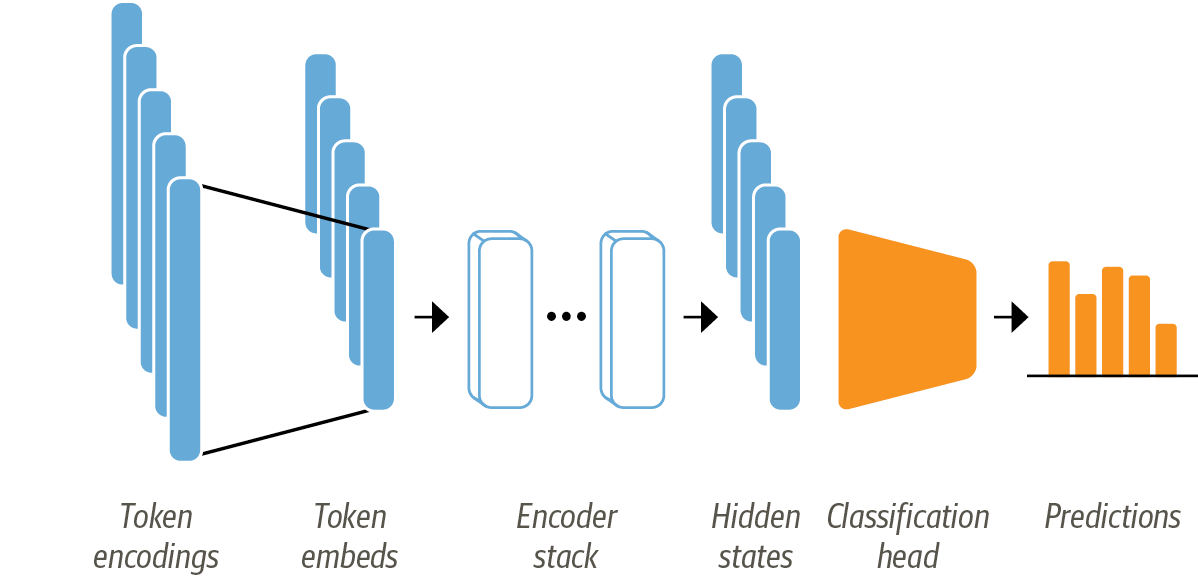

In [12]:
Image("images/chapter02_encoder-classifier.png", width=800)

Primero, el texto se tokeniza y se representa como vectores one-hot llamados _token encodings_. El tamaño del vocabulario del tokenizer determina la dimensión de los token encodings, y generalmente consiste en 20k–200k tokens únicos. Luego, estos token encodings se convierten en _token embeddings_, que son vectores que viven en un espacio de menor dimensión. Los token embeddings se pasan a través de las capas del bloque del encoder para producir un _estado oculto_ para cada token de entrada. Para el objetivo de preentrenamiento de modelado de lenguaje, cada estado oculto se alimenta a una capa que predice los tokens de entrada enmascarados. Para la tarea de clasificación, reemplazamos la capa de modelado de lenguaje con una capa de clasificación.

> nota: En la práctica, PyTorch omite el paso de crear vectores one-hot para los token encodings porque multiplicar una matriz con un vector one-hot es lo mismo que seleccionar una columna de la matriz. Esto se puede hacer directamente obteniendo la columna con el ID del token de la matriz. Esto sucede cuando por ejemplo se usa la clase `nn.Embedding`.

Tenemos dos opciones para entrenar un modelo así en nuestro conjunto de datos de Twitter:

- _Extracción de características_:: Usamos los estados ocultos como características y solo entrenamos un clasificador sobre ellos, sin modificar el modelo preentrenado.
- _Fine-tuning_:: Entrenamos todo el modelo de principio a fin, lo que también actualiza los parámetros del modelo preentrenado.

En las siguientes secciones exploramos ambas opciones para DistilBERT y examinamos sus ventajas y desventajas.

### Transformers como Extractores de Características

Usar un transformer como extractor de características es bastante simple. Como se muestra en la siguiente figura, congelamos los pesos del cuerpo durante el entrenamiento y usamos los estados ocultos como características para el clasificador. La ventaja de este enfoque es que podemos entrenar rápidamente un modelo pequeño o superficial. Tal modelo podría ser una capa de clasificación neuronal o un método que no dependa de gradientes, como un random forest. Este método es especialmente conveniente si no se dispone de GPUs, ya que los estados ocultos solo necesitan precomputarse una vez.

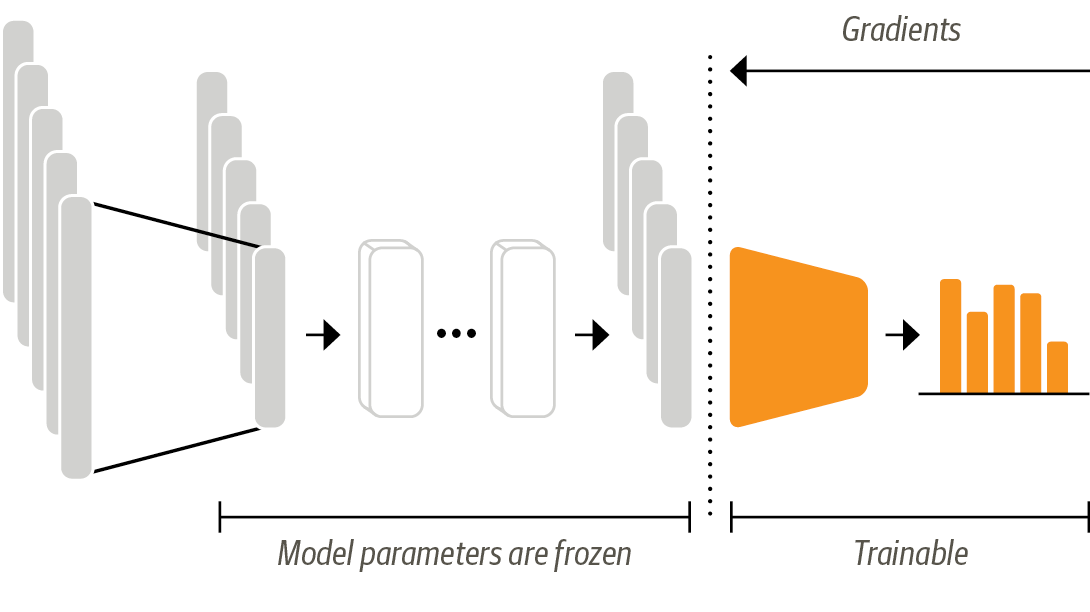

In [14]:
Image("images/chapter02_encoder-feature-based.png", width=800)

#### Usando modelos preentrenados

Usaremos otra clase _Auto_ conveniente de Hugging Face Transformers llamada `AutoModel`. Similar a la clase `AutoTokenizer`, `AutoModel` tiene un método `from_pretrained()` para cargar los pesos de un modelo preentrenado. Usemos este método para cargar el checkpoint de DistilBERT.

In [ ]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Aquí hemos usado PyTorch para verificar si hay una GPU disponible o no, y luego encadenamos el método `nn.Module.to()` de PyTorch al cargador del modelo. Esto asegura que el modelo se ejecutará en la GPU si tenemos una. Si no, el modelo se ejecutará en la CPU, lo que puede ser considerablemente más lento.

La clase `AutoModel` convierte los token encodings en embeddings, y luego los alimenta a través de la pila del encoder para devolver los estados ocultos. Veamos cómo podemos extraer estos estados de nuestro corpus.

#### Extrayendo los últimos estados ocultos

Para calentar, recuperemos los últimos estados ocultos para una sola cadena. Lo primero que necesitamos hacer es codificar la cadena y convertir los tokens en tensores de PyTorch. Esto se puede hacer proporcionando el argumento `return_tensors="pt"` al tokenizer de la siguiente manera:

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


Como podemos ver, el tensor resultante tiene la forma `[batch_size, n_tokens]`. Ahora que tenemos las codificaciones como un tensor, el paso final es colocarlas en el mismo dispositivo que el modelo y pasar las entradas de la siguiente manera:

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Aquí hemos usado `torch.no_grad()` para deshabilitar el cálculo automático del gradiente. Esto es útil para la inferencia ya que reduce la huella de memoria de los cálculos. Dependiendo de la configuración del modelo, la salida puede contener varios objetos, como los estados ocultos, pérdidas o atenciones, organizados en una clase similar a un `namedtuple` en Python. En nuestro ejemplo, la salida del modelo es una instancia de `BaseModelOutput`, y simplemente podemos acceder a sus atributos por nombre. El modelo actual solo devuelve un atributo, que es el último estado oculto, así que examinemos su forma:


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Mirando el tensor del estado oculto, vemos que tiene la forma `[batch_size, n_tokens, hidden_dim]`. En otras palabras, se devuelve un vector de 768 dimensiones para cada uno de los 6 tokens de entrada. Para tareas de clasificación, es una práctica común usar solo el estado oculto asociado con el token `[CLS]` como la característica de entrada. Dado que este token aparece al inicio de cada secuencia, podemos extraerlo simplemente indexando en `outputs.last_hidden_state` de la siguiente manera:

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Ahora que sabemos cómo obtener el último estado oculto para una sola cadena, hagamos lo mismo para todo el conjunto de datos creando una nueva columna `hidden_state` que almacene todos estos vectores. Como hicimos con el tokenizer, usaremos el método `map()` de `DatasetDict` para extraer todos los estados ocultos de una vez. Lo primero que necesitamos hacer es envolver los pasos anteriores en una función de procesamiento:

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

La única diferencia entre esta función y nuestra lógica anterior es el paso final donde colocamos el estado oculto final de nuevo en la CPU como un array de NumPy. El método `map()` requiere que la función de procesamiento devuelva objetos de Python o NumPy cuando estamos usando entradas por lotes.

Dado que nuestro modelo espera tensores como entradas, lo siguiente que debemos hacer es convertir las columnas `input_ids` y `attention_mask` al formato `"torch"`, de la siguiente manera:

In [ ]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

Luego podemos proceder a extraer los estados ocultos en todos los splits de una vez:

In [ ]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Ten en cuenta que no establecimos `batch_size=None` en este caso, por lo que se usa el valor predeterminado `batch_size=1000`. Como era de esperar, aplicar la función `extract_hidden_states` ha añadido una nueva columna `hidden_state` a nuestro conjunto de datos:

In [ ]:
emotions_hidden["train"].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

Ahora que tenemos los estados ocultos asociados con cada tweet, el siguiente paso es entrenar un clasificador sobre ellos. Para hacer eso, necesitaremos una matriz de características - echemos un vistazo.

#### Creando una matriz de características

El conjunto de datos preprocesado ahora contiene toda la información que necesitamos para entrenar un clasificador sobre él. Usaremos los estados ocultos como características de entrada y las etiquetas como objetivos. Podemos crear fácilmente los arrays correspondientes en el formato bien conocido de Scikit-Learn de la siguiente manera:

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Antes de entrenar un modelo sobre los estados ocultos, es una buena práctica realizar una verificación de cordura para asegurarnos de que proporcionan una representación útil de las emociones que queremos clasificar. En la siguiente sección, veremos cómo visualizar las características proporciona una forma rápida de lograr esto.

#### Visualizando el conjunto de entrenamiento

Dado que visualizar los estados ocultos en 768 dimensiones es complicado por decir lo menos, usaremos el poderoso algoritmo UMAPfootnote:[L. McInnes, J. Healy, y J. Melville, ["UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction"](https://arxiv.org/abs/1802.03426), (2018).] para proyectar los vectores a 2D. Dado que UMAP funciona mejor cuando las características están escaladas para estar en el intervalo [0,1], primero aplicaremos un `MinMaxScaler` y luego usaremos la implementación de UMAP de la biblioteca `umap-learn` para reducir los estados ocultos:

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.358075,6.140816,0
1,-3.134567,5.329446,0
2,5.152230,2.732643,3
3,-2.519018,3.067250,2
4,-3.364520,3.356613,3


El resultado es un array con el mismo número de muestras de entrenamiento, pero con solo 2 características en lugar de las 768 con las que comenzamos. Investigamos un poco más los datos comprimidos y trazamos la densidad de puntos para cada categoría por separado:

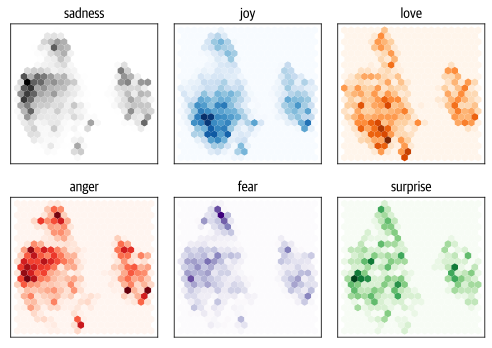

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


>nota: Estas son solo proyecciones a un espacio de menor dimensión. Solo porque algunas categorías se superpongan no significa que no sean separables en el espacio original. Por el contrario, si son separables en el espacio proyectado, serán separables en el espacio original.

De este gráfico podemos ver algunos patrones claros: los sentimientos negativos como `sadness`, `anger` y `fear` ocupan regiones similares con distribuciones ligeramente diferentes. Por otro lado, `joy` y `love` están bien separados de las emociones negativas y también comparten un espacio similar. Finalmente, `surprise` está disperso por todas partes. Aunque podríamos haber esperado alguna separación, esto no está garantizado ya que el modelo no fue entrenado para conocer la diferencia entre estas emociones. Solo las aprendió implícitamente al adivinar las palabras enmascaradas en los textos.

Ahora que hemos obtenido una idea de las características de nuestro conjunto de datos, ¡finalmente entrenemos un modelo sobre él!

#### Entrenando un clasificador simple

Hemos visto que los estados ocultos son algo diferentes entre las emociones, aunque para varias de ellas no hay un límite obvio. Usemos estos estados ocultos para entrenar un modelo de regresión logística con Scikit-Learn. Entrenar un modelo tan simple es rápido y no requiere una GPU:

In [ ]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.6085

Mirando la accuracy, podría parecer que nuestro modelo es solo un poco mejor que al azar, pero dado que estamos tratando con un conjunto de datos multiclase desequilibrado, en realidad es significativamente mejor. Podemos examinar si nuestro modelo es bueno comparándolo con una línea base simple. En Scikit-Learn hay un `DummyClassifier` que se puede usar para construir un clasificador con heurísticas simples como siempre elegir la clase mayoritaria o siempre elegir una clase al azar. En este caso, la heurística de mejor rendimiento es siempre elegir la clase más frecuente, lo que produce una precisión de alrededor del 35%:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Entonces, nuestro clasificador simple con embeddings de DistilBERT es significativamente mejor que nuestra línea base. Podemos investigar más a fondo el rendimiento del modelo observando la matriz de confusión del clasificador, que nos dice la relación entre las etiquetas verdaderas y las predichas:

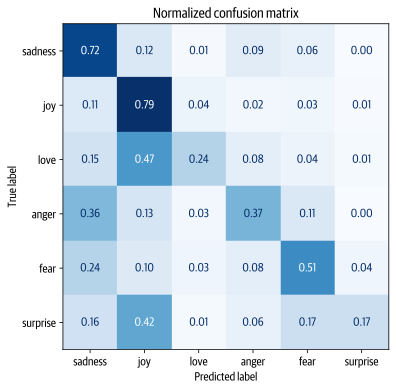

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Podemos ver que `anger` y `fear` se confunden más a menudo con `sadness`, lo cual concuerda con la observación que hicimos al visualizar los embeddings. Además, `love` y `surprise` se confunden frecuentemente con `joy`.

En la siguiente sección exploraremos el enfoque de fine-tuning, que conduce a un rendimiento de clasificación superior. Sin embargo, es importante notar que hacer esto requiere más recursos computacionales, como GPUs, que podrían no estar disponibles en tu organización. En casos como estos, un enfoque basado en características puede ser un buen compromiso entre hacer machine learning tradicional y deep learning.

### Fine-Tuning Transformers

Ahora exploremos lo que se necesita para hacer fine-tuning a un transformer de principio a fin. Con el enfoque de fine-tuning no usamos los estados ocultos como características fijas, sino que los entrenamos como se muestra en la siguiente figura. Esto requiere que la cabeza de clasificación sea diferenciable, por lo que este método usualmente usa una red neuronal para la clasificación.

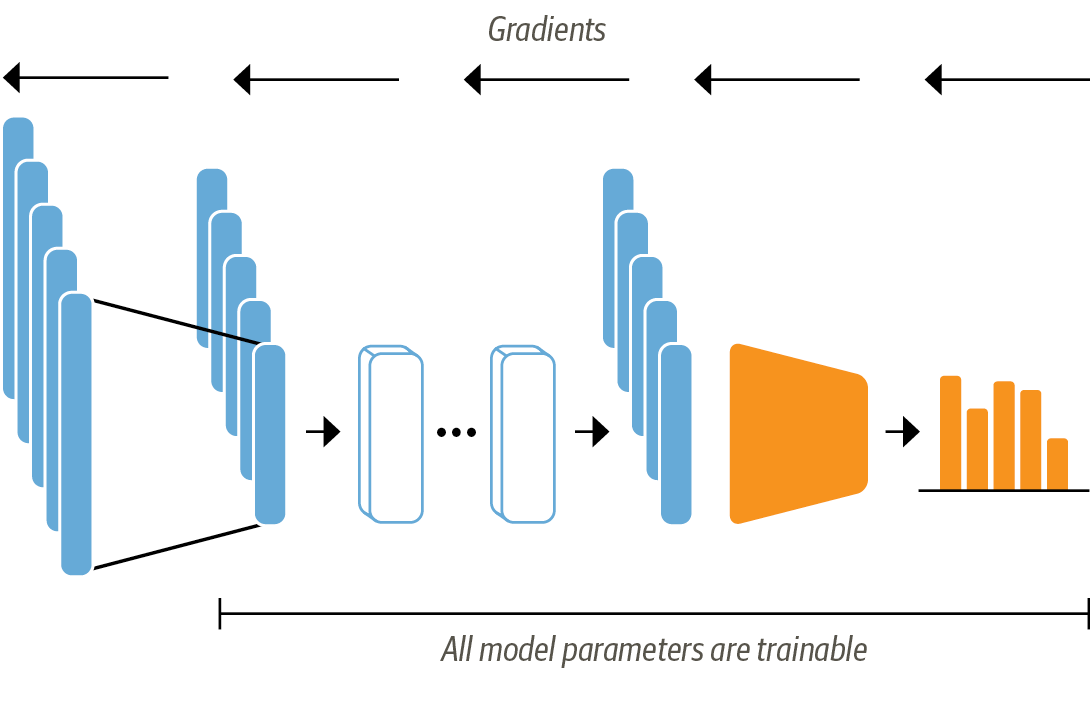

In [16]:
Image("images/chapter02_encoder-fine-tuning.png", width=800)

Entrenar los estados ocultos que sirven como entradas al modelo de clasificación nos ayudará a evitar el problema de trabajar con datos que pueden no ser adecuados para la tarea de clasificación. En su lugar, los estados ocultos iniciales se adaptan durante el entrenamiento para disminuir la pérdida del modelo y así aumentar su rendimiento.

Usaremos la API `Trainer` de HF Transformers para simplificar el bucle de entrenamiento. ¡Veamos los ingredientes que necesitamos para configurarlo!

#### Cargando un modelo preentrenado

Lo primero que necesitamos es un modelo DistilBERT preentrenado como el que usamos en el enfoque basado en características. La única ligera modificación es que usamos el modelo `AutoModelForSequenceClassification` en lugar de `AutoModel`. La diferencia es que el modelo `AutoModelForSequenceClassification` tiene una cabeza de clasificación sobre las salidas del modelo preentrenado, que se puede entrenar fácilmente con el modelo base. Solo necesitamos especificar cuántas etiquetas tiene que predecir el modelo (seis en nuestro caso), ya que esto dicta el número de salidas que tiene la cabeza de clasificación:

In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Verás un warning de que algunas partes del modelo se inicializan aleatoriamente. Esto es normal ya que la cabeza de clasificación aún no ha sido entrenada. El siguiente paso es definir las métricas que usaremos para evaluar el rendimiento de nuestro modelo durante el fine-tuning.

#### Definiendo las métricas de rendimiento

Para monitorear las métricas durante el entrenamiento, necesitamos definir una función `compute_metrics()` para el `Trainer`. Esta función recibe un objeto `EvalPrediction` (que es una tupla con atributos `predictions` y `label_ids`) y necesita devolver un diccionario que mapee el nombre de cada métrica a su valor. Para nuestra aplicación, calcularemos el $F_1$-score y la precisión del modelo de la siguiente manera:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Con el conjunto de datos y las métricas listas, solo nos quedan dos cosas finales por hacer antes de definir la clase `Trainer`:

1. Iniciar sesión en nuestra cuenta en el Hugging Face Hub. Esto nos permitirá subir nuestro modelo fine-tuned a nuestra cuenta en el Hub y compartirlo con la comunidad.
2. Definir todos los hiperparámetros para la ejecución del entrenamiento.

Abordaremos estos pasos en la siguiente sección.

#### Entrenando el modelo

Si estás ejecutando este código en un notebook de Jupyter, puedes iniciar sesión en el Hub con la siguiente función de ayuda:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

in[193]: Esto mostrará un widget en el que puedes ingresar tu nombre de usuario y contraseña, o un token de acceso con privilegios de escritura. Puedes encontrar detalles sobre cómo crear tokens de acceso en la [documentación del Hub](https://huggingface.co/docs/hub/security#user-access-tokens). Si estás trabajando en la terminal, puedes iniciar sesión ejecutando el siguiente comando:

```bash
$ huggingface-cli login
```

Para definir los parámetros de entrenamiento, usamos la clase `TrainingArguments`. Esta clase almacena mucha información y te da un control detallado sobre el entrenamiento y la evaluación. El argumento más importante a especificar es `output_dir`, que es donde se almacenan todos los artefactos del entrenamiento. Aquí hay un ejemplo de `TrainingArguments` en todo su esplendor:

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

Aquí también establecemos el tamaño del lote, la tasa de aprendizaje y el número de épocas, y especificamos cargar el mejor modelo al final de la ejecución del entrenamiento. Con este ingrediente final, podemos instanciar y hacer fine-tuning a nuestro modelo con el `Trainer`:

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.840900,0.327445,0.896500,0.892285
2,0.255000,0.220472,0.922500,0.922550


Mirando los logs, podemos ver que nuestro modelo tiene un $F_1$-score en el conjunto de validación de alrededor del 92% - ¡esto es una mejora significativa sobre el enfoque basado en características!

Podemos echar un vistazo más detallado a las métricas de entrenamiento calculando la matriz de confusión. Para visualizar la matriz de confusión, primero necesitamos obtener las predicciones en el conjunto de validación. El método `predict()` de la clase `Trainer` devuelve varios objetos útiles que podemos usar para la evaluación:

In [ ]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

La salida del método `predict()` es un objeto `PredictionOutput` que contiene arrays de `predictions` y `label_ids`, junto con las métricas que pasamos al entrenador. Por ejemplo, las métricas en el conjunto de validación se pueden acceder de la siguiente manera:

In [ ]:
preds_output.metrics

{'test_loss': 0.22047173976898193,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225500751072866,
 'test_runtime': 1.6357,
 'test_samples_per_second': 1222.725,
 'test_steps_per_second': 19.564}

También contiene las predicciones en bruto para cada clase. Podemos decodificar las predicciones de manera codiciosa usando `np.argmax()`. Esto produce las etiquetas predichas y tiene el mismo formato que las etiquetas devueltas por los modelos de Scikit-Learn en el enfoque basado en características:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

Con las predicciones, podemos trazar la matriz de confusión nuevamente:

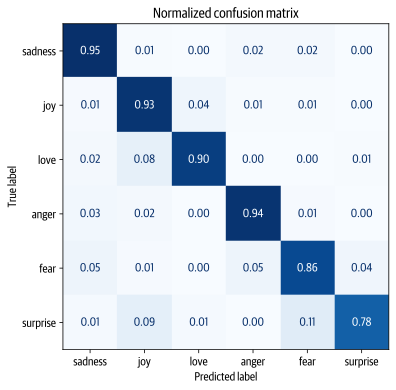

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

Esto está mucho más cerca de la matriz de confusión diagonal ideal. La categoría `love` todavía se confunde a menudo con `joy`, lo cual parece natural. `surprise` también se confunde frecuentemente con `joy`, o se confunde con `fear`. En general, el rendimiento del modelo parece bastante bueno, pero antes de darlo por terminado, profundicemos un poco más en los tipos de errores que es probable que cometa nuestro modelo.

#### Error analysis

Antes de continuar, deberíamos investigar un poco más las predicciones de nuestro modelo. Una técnica simple pero poderosa es ordenar las muestras de validación por la pérdida del modelo. Cuando pasamos la etiqueta durante el forward pass, la pérdida se calcula y devuelve automáticamente. Aquí hay una función que devuelve la pérdida junto con la etiqueta predicha:

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

Usando el método `map()` una vez más, podemos aplicar esta función para obtener las pérdidas de todas las muestras:

In [ ]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

Finalmente, creamos un `DataFrame` con los textos, pérdidas y etiquetas predichas/verdaderas:

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Ahora podemos ordenar fácilmente `emotions_encoded` por las pérdidas en orden ascendente o descendente. El objetivo de este ejercicio es detectar uno de los siguientes:

- _Etiquetas incorrectas_: Todo proceso que añade etiquetas a los datos puede ser defectuoso. Los anotadores pueden cometer errores o no estar de acuerdo, mientras que las etiquetas que se infieren de otras características pueden estar equivocadas. Si fuera fácil anotar datos automáticamente, entonces no necesitaríamos un modelo para hacerlo. Por lo tanto, es normal que haya algunos ejemplos mal etiquetados. Con este enfoque, podemos encontrarlos y corregirlos rápidamente.

- _Particularidades del conjunto de datos_: Los conjuntos de datos en el mundo real siempre son un poco desordenados. Cuando se trabaja con texto, los caracteres especiales o cadenas en las entradas pueden tener un gran impacto en las predicciones del modelo. Inspeccionar las predicciones más débiles del modelo puede ayudar a identificar tales características, y limpiar los datos o inyectar ejemplos similares puede hacer que el modelo sea más robusto.

Primero echemos un vistazo a las muestras de datos con las pérdidas más altas:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.704531
1963,i called myself pro life and voted for perry w...,joy,sadness,5.484461
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.434768
882,i feel badly about reneging on my commitment t...,love,sadness,5.257482
1950,i as representative of everything thats wrong ...,surprise,sadness,4.827708
1509,i guess this is a memoir so it feels like that...,joy,fear,4.713047
1274,i am going to several holiday parties and i ca...,joy,sadness,4.704955
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.656096
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.593202
1111,im lazy my characters fall into categories of ...,joy,fear,4.311287


Podemos ver claramente que el modelo predijo algunas de las etiquetas incorrectamente. Por otro lado, parece que hay bastantes ejemplos sin una clase clara, que podrían estar mal etiquetados o requerir una nueva clase por completo. En particular, `joy` parece estar mal etiquetado varias veces. Con esta información podemos refinar el conjunto de datos, lo que a menudo puede llevar a una ganancia de rendimiento tan grande (o más) como tener más datos o modelos más grandes.

Al observar las muestras con las pérdidas más bajas, observamos que el modelo parece estar más seguro al predecir la clase `sadness`. Los modelos de deep learning son excepcionalmente buenos para encontrar y explotar atajos para llegar a una predicción. Por esta razón, también vale la pena invertir tiempo en observar los ejemplos sobre los que el modelo está más seguro, para que podamos estar seguros de que el modelo no explota indebidamente ciertas características del texto. Así que, también echemos un vistazo a las predicciones con la menor pérdida:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017331
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.017392
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017400
392,i remember feeling disheartened one day when w...,sadness,sadness,0.017461
1310,i feel like an ungrateful asshole,sadness,sadness,0.017485
189,i leave the meeting feeling more than a little...,sadness,sadness,0.017670
1120,i am feeling a little disheartened,sadness,sadness,0.017685
783,i feel like i deserve to be broke with how fri...,sadness,sadness,0.017888
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017899
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017913


Ahora sabemos que `joy` a veces está mal etiquetado y que el modelo está más seguro al predecir la etiqueta `sadness`. Con esta información podemos hacer mejoras específicas a nuestro conjunto de datos, y también estar atentos a la clase sobre la que el modelo parece estar muy seguro.

El último paso antes de servir el modelo entrenado es guardarlo para su uso posterior. HF Transformers nos permite hacer esto en unos pocos pasos, que te mostraremos en la siguiente sección.

#### Guardando y compartiendo el modelo

La comunidad de NLP se beneficia enormemente de compartir modelos preentrenados y fine-tuned, y todos pueden compartir sus modelos con otros a través del Hugging Face Hub. Cualquier modelo generado por la comunidad se puede descargar del Hub tal como descargamos el modelo DistilBERT. Con la API `Trainer`, guardar y compartir un modelo es simple:

In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/lewtun/distilbert-base-uncased-finetuned-emotion/commit/352c4147e4754f73a0b41f7b175f4a907270c9c9'

También podemos usar el modelo fine-tuned para hacer predicciones en nuevos tweets. Dado que hemos subido nuestro modelo al Hub, ahora podemos usarlo con la función `pipeline()`. Primero, carguemos el pipeline:

In [ ]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Entonces, probemos el pipeline con un tuit de ejemplo:

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

Finalmente, podemos trazar la probabilidad para cada clase en un gráfico de barras. Claramente, el modelo estima que la clase más probable es `joy`, lo cual parece razonable dado el tweet:

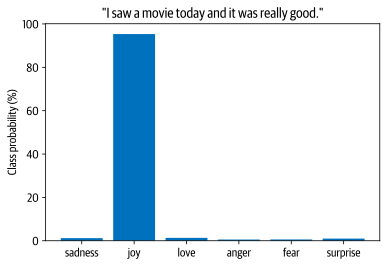

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusión

¡Felicidades, ahora sabes cómo entrenar un modelo transformer para clasificar las emociones en tweets! Hemos visto dos enfoques complementarios basados en características y fine-tuning, y hemos investigado sus fortalezas y debilidades.

Sin embargo, este es solo el primer paso para construir una aplicación del mundo real con modelos transformer, y tenemos mucho más terreno por cubrir. Aquí hay una lista de desafíos que probablemente experimentarás en tu viaje de NLP:

Mi jefe quiere mi modelo en producción ayer!:
En la mayoría de las aplicaciones, tu modelo no solo se sienta en algún lugar acumulando polvo - ¡quieres asegurarte de que está sirviendo predicciones! Cuando un modelo se sube al Hub, se crea automáticamente un endpoint de inferencia que se puede llamar con solicitudes HTTP. Recomendamos revisar la [documentación](https://api-inference.huggingface.co/docs/python/html/index.html) de la API de Inferencia si quieres aprender más.

¡Mis usuarios quieren predicciones más rápidas!:
Ya hemos visto un enfoque para este problema: usar DistilBERT. En <<chapter_compression>> profundizaremos en la destilación de conocimiento (el proceso por el cual se creó DistilBERT), junto con otros trucos para acelerar tus modelos transformer.

¿Puede tu modelo también hacer X?:
Como hemos insinuado en este capítulo, los transformers son extremadamente versátiles. En el resto del libro exploraremos una gama de tareas, como question answering y named entity recognition, todo usando la misma arquitectura básica.

¡Ninguno de mis textos está en inglés!:
Resulta que los transformers también vienen en una variedad multilingüe

¡No tengo ninguna etiqueta!::
Si hay muy pocos datos etiquetados disponibles, el fine-tuning puede no ser una opción. 